In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# 构建EncoderDecoder

In [2]:
class EncoderDecoder(nn.Module):
    """
    标准的编码器-解码器结构
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # 输入和输出嵌入
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        # decoder最后的linear+softmax
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        # 接收并处理屏蔽源和目标序列
        # 先调用encode对输入编码，然后用decode解码
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
# gengeate类
class Generator(nn.Module):
    """全连接+softmax"""
    # 依据解码器的隐状态输出一个词
    # d_model是解码器输出的大小， vocab是词典大小
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim = -1) # 特征保存在特征空间的最后一个维度

# 构建编码器

In [4]:
# 定义复制模块的函数
def clone(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N) ])

In [5]:
# 定义encoder
class Encoder(nn.Module):
    """由n个EncoderLayer组成"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clone(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x, x_mask):
        for layer in self.layers:
            x = layer(x, x_mask)
        return self.norm(x)

In [6]:
# 定义layernorm
class layernorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2*(x-mean)/(std+self.eps) + self.b_2

In [7]:
# lay = layernorm(100)

In [8]:
# 构建sublayerconnection
class SubLayerConnection(nn.Module):
    """
    Layernorm + sublayer(att/dense) + dropout + reset
    """
    def __init__(self, size, dropout):
        super(SubLayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x+self.dropout(sublayer(self.norm(x)))

In [9]:
# 构建EncoderLayer
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SubLayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

# 构建解码器

In [10]:
# 定义decoder
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clone(layer, N)
        self.norm = nn.LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [11]:
# 定义DecoderLayer
class DecoderLayer(nn.Module):
    """self_attn + src_attn + feed_forward"""
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SubLayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [12]:
# 定义subsequent_mask
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # 返回上三角矩阵
    return torch.from_numpy(subsequent_mask) == 0

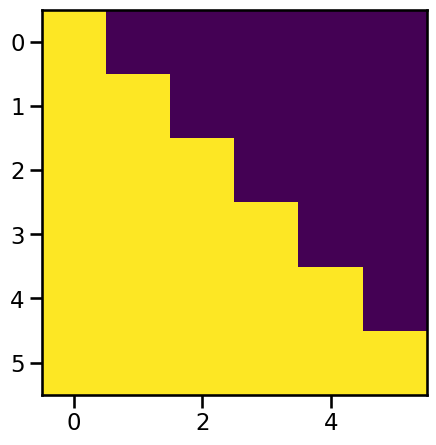

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(6)[0])

# 构建多头注意力

In [14]:

# 计算点积注意力
def attention(query, key, value, mask=None, dropout=None):
    """计算缩放点积注意力"""
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask==0, -le9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [15]:
# 定义多头注意力
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clone(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) \
                             for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=None, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h*self.d_k)
        return self.linears[-1](x)

# 构建前馈神经网络

In [16]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# 预处理数据  

In [17]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x)*math.sqrt(self.d_model)

In [18]:
# 位置编码
class PositionalEncodeing(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncodeing, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)* -(math.log(1000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].clone().detach()
        return self.dropout(x)

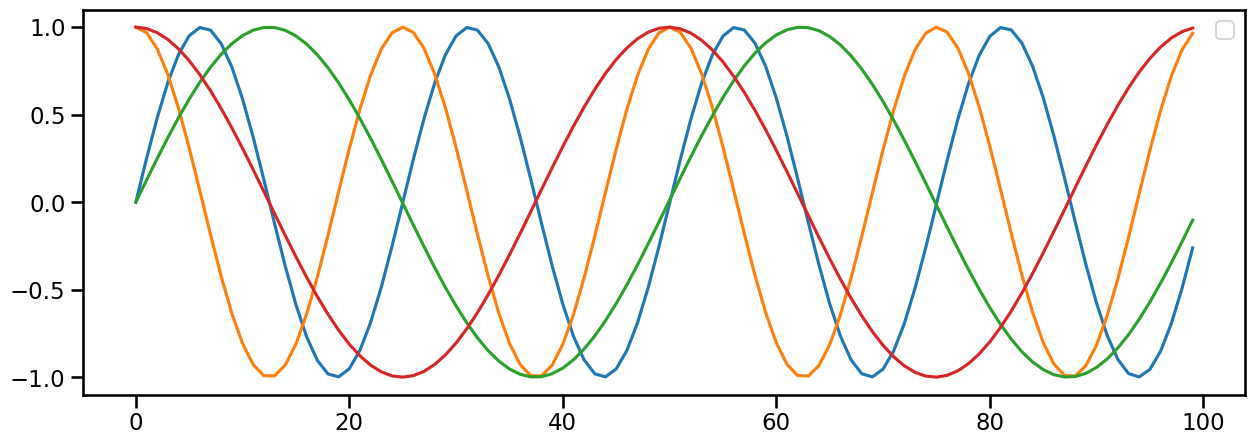

In [19]:
# 验证位置编码
plt.figure(figsize=(15,5))
pe = PositionalEncodeing(20,0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend("dim %d" %p for p in [4,5,6,7])

# 构建完整网络

In [20]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncodeing(d_model, dropout)
    model = EncoderDecoder(Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
                           Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
                           nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
                           nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
                           Generator(d_model, tgt_vocab))
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [21]:
nets = make_model(10, 10, 2)
nets

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SubLayerConnection(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SubLayerC

# 训练模型

In [22]:
class Batch:
    """构建带有掩码的批量数据"""
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg != None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data).clone().detach()
        return tgt_mask

In [23]:
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("epoch step: %d Loss: %f Tokens per Sec: %f" %(i, loss/batch.ntokens, tokens/elapsed))
            start = time.time()
            tokens = 0
    return total_loss/total_tokens

In [24]:
# 批量处理数据
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.tgt) + 2)
    src_elements = count*max_src_in_batch
    tgt_elements = count*max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [36]:
# 定义优化器
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
    
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor*(self.model_size**(-0.5)*min(step**(-0.5), step*self.warmup**(-1.5)))
    
    def get_std_opt(model):
        return NoamOpt(model.src_embed[0].d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98),eps=1e-9))

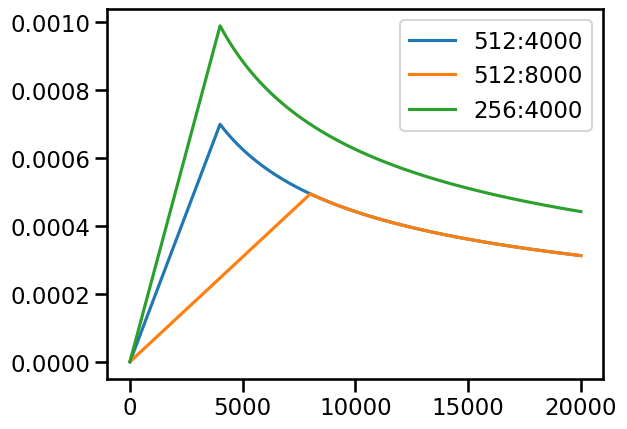

In [27]:
# 可视化学习率
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

In [31]:
# 正则化
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size -2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

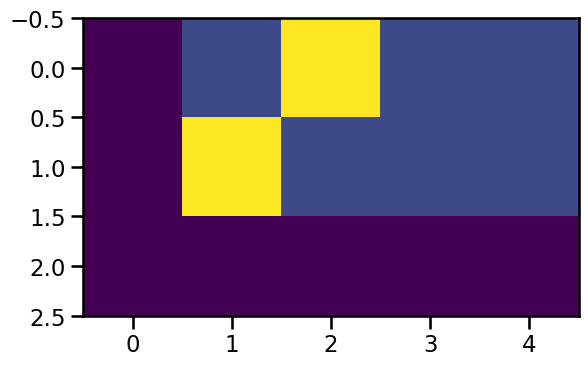

In [32]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor(([0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]))
v = crit(predict.log().clone().detach(), torch.LongTensor([2, 1, 0]).clone().detach())
plt.imshow(crit.true_dist)

In [33]:
# 生成合成数据
def data_gen(V, batch, nbatchs):
    for i in range(nbatchs):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))).long()
        data[:, 0] = 1
        src = data.clone().detach()
        tgt = data.clone().detach()
        yield Batch(src, tgt, 0)

In [34]:
# 定义损失函数
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [37]:
# 训练
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, SimpleLossCompute(model.generator, criterion, None)))

epoch step: 1 Loss: 2.959010 Tokens per Sec: 0.000000
epoch step: 1 Loss: 2.047762 Tokens per Sec: 0.000000
tensor(2.0378)
epoch step: 1 Loss: 1.913277 Tokens per Sec: 0.000000
epoch step: 1 Loss: 1.837196 Tokens per Sec: 0.000000
tensor(1.8726)
epoch step: 1 Loss: 1.852757 Tokens per Sec: 0.000000
epoch step: 1 Loss: 1.782713 Tokens per Sec: 0.000000
tensor(1.7697)
epoch step: 1 Loss: 1.824851 Tokens per Sec: 0.000000
epoch step: 1 Loss: 1.617323 Tokens per Sec: 0.000000
tensor(1.6189)
epoch step: 1 Loss: 1.755883 Tokens per Sec: 0.000000
epoch step: 1 Loss: 1.319876 Tokens per Sec: 0.000000
tensor(1.3035)
epoch step: 1 Loss: 1.317532 Tokens per Sec: 0.000000
epoch step: 1 Loss: 0.511210 Tokens per Sec: 0.000000
tensor(0.4969)
epoch step: 1 Loss: 0.663428 Tokens per Sec: 0.000000
epoch step: 1 Loss: 0.107246 Tokens per Sec: 0.000000
tensor(0.1426)
epoch step: 1 Loss: 0.242838 Tokens per Sec: 0.000000
epoch step: 1 Loss: 0.139858 Tokens per Sec: 0.000000
tensor(0.1450)
epoch step: 1 Lo